In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import re

# Входные параметры

[nucleus] - определённое ядро, для которого нужно вычислить плотность уровней. Записывается в строковом формате: 39K, 40Ca, 58Ni и т.п. Регистр не важен.

[U] - энергия, вплоть до которой нужно вычислить плотность уровней. Формат: целое число в МэВ.

[file] - название файла, из которого извлекается информация об одночастичных состояниях ядра.

[pairs_2Delta] - булева переменная. Если True, то в расчёте учитывается, что пару нуклонов можно разъединить, но при этом оставить нуклоны в своих одночастичных состояниях. Если False, то это предположение не будет учитываться.

# Внутренние переменные

[A]- массовое число, определяемое из [nucleus]

[N_p]- число протонов, определяемое из [nucleus]

[N_n] - аналогично.

[p_levels]- количество энергетических уровней для протонов

[n_levels] - аналогично.

[DP] - энергия спаривания для протонов

[DN] - аналогично.

[GP] - параметр силы парного взаимодействия для протонов.

[GN] - аналогично.

[E_0_proton] - энергия основного состояния для протонов.

[E_0_neutron] - аналогично.

[E_F_proton] - энергия Ферми для протонов.

[E_F_neutron] - аналогично.

[energy_step] - шаг в распределении по энергии в МэВ. Обычно это целое число.

[j2z_limit] - максимальное значение удвоенной проекции углового момента. Если у некоторого многочастичного состояния будет рассчитано j2z > j2z_limit или -j2z < -j2z_limit, то возникнет ошибка. Значение j2z_limit выбирается с запасом; обычно оно равно 50.

[level_count] - массив количеств многочастичных состояний в интервалах шириной [energy_step], соответствующих энергии от 0 до $int(\frac{U_{max}}{\text{energy\_step}})$.

[dN[n]_over_dU_over_d2jz_pariry[P]] - словарь (dictionary) для нейтронов [n], в котором ключами являются энергии возбуждения с шагом [energy_step], а значениями - массивы, каждый индекс которого соответствует определённой проекции углового момента 2jz. Указывая энергию и проекцию углового момента, можно получить количество многочастичных состояний с положительной чётностью [P] с заданными параметрами. Например, dNn_over_dU_over_d2jz_pariryP[7][56] выдаст количество многочастичных состояний в интервале энергий [7, 8) МэВ, с проекцией углового момента $J_Z$ - [j2z_limit] = 6/2 = 3 и с положительной чётностью $P=1$.

[dNn_over_dU_over_d2jz_pariryN] - аналогично.

[dNp_over_dU_over_d2jz_pariryP] - аналогично.

[dNp_over_dU_over_d2jz_pariryN] - аналогично.

[dNp_over_dU] - словарь (dictionary) для протонов, в котором ключами являются энергии возбуждения с шагом [energy_step], а значениями - числа, количества многочастичных состояний в определённых интервалах энергий. Например, dNp_over_dU[7] выдаст количество многочастичных состояний в интервале энергий [7, 8) МэВ.

[dNn_over_dU] - аналогично.

[N_states] - в расчёте для протонов принимает значение [proton_nstates], для нейтронов - [neutron_nstates].

[E_F] - в расчёте для протонов принимает значение [E_F_proton], для нейтронов - [E_F_neutron].

[nucl_type] - в расчёте для протонов принимает строковое значение 'p', для нейтронов - 'n'.

[E_0] - в расчёте для протонов принимает значение [E_0_proton], для нейтронов - [E_0_neutron].

[N] - в расчёте для протонов принимает значение [N_p], для нейтронов - [N_n].

[parity] - в расчёте для протонов принимает значение [proton_parity], для нейтронов - [neutron_parity].

[j2z] - в расчёте для протонов принимает значение [proton_j2z], для нейтронов - [neutron_j2z].

[D] - в расчёте для протонов принимает значение [DP], для нейтронов - [DN].

[E] - в расчёте для протонов принимает значение [proton_energies], для нейтронов - [neutron_energies].

[array] - массив чисел заполнения одночастичных состояний, состоящий из нулей (состояние не занято) и единиц (состояние занято). Когда производится расчёт для протонов, длина массива равна [proton_nstates], в случае нейтронов - [neutron_nstates].

[iteration_array] - вспомогательный массив...

[array_energy_pairing] - функция, которая рассчитывает энергию многочастичного состояния с учётом спаривания нуклонов. Возвращает массив, в котором каждый элемент является двумерным массивом [sum, n]. Здесь sum - энергия многочастичного состояния, n - количество многочастичных состояний, соответствующий определённому количеству разъединённых пар. Например, в массиве [[100, 1], [110, a], [120, b]] будет суммарно 1+a+b многочастичных состояний. Первый элемент [100, 1] соответствует случаю, когда разрыв пары не учитывается. Во втором элементе [110, a] разъединена одна пара, что даёт a многочастичных состояний. В третьем элементе [120, b] разъединены две пары, что даёт b многочастичных состояний.

[array_parity] - функция, которая рассчитывает чётность многочастичного состояния. Возвращает 1, если чётность положительна, и -1, если отрицательна. Использует в расчёте [parity].

[array_j2z] - функция, которая рассчитывает удвоенную проекцию полного углового момента многочастичного состояния. Использует в расчёте [j2z].






In [2]:
nucleus = '58Ni'
U = 30
file = 'SLy4/Ni58_BCSd/Ni58_SLy4.1'
pairs_2Delta = False # True of False
new_Delta_flag = False

In [3]:
# Определение массового числа [A], числа протонов [N_p] и нейтронов [N_n] из [nucleus]

element = { 11: 'na', 12: 'mg', 13: 'al', 14: 'si', 15: 'p', 16: 's', 17: 'cl', 18: 'ar', 19: 'k', 20: 'ca', 21: 'sc', 22: 'ti', 23: 'v', 24: 'cr', 25: 'mn', 26: 'fe', 27: 'co', 28: 'ni', 29: 'cu', 30: 'zn', 31: 'ga', 32: 'ge', 33: 'as', 34: 'se', 35: 'br', 36: 'kr', 37: 'rb', 38: 'sr', 39: 'y', 40: 'zr', 41: 'nb', 42: 'mo', 43: 'tc', 44: 'ru', 45: 'rh', 46: 'pd', 47: 'ag', 48: 'cd', 49: 'in', 50: 'sn'}

num_len = len(re.findall(r'\d', nucleus))
A = int(nucleus[0:num_len])
N_p = list(element.keys())[list(element.values()).index(nucleus[num_len:].lower())]
N_n = A - N_p

# Определение изначальных параметров

Ni58: 
p_levels = 10
n_levels = 12

Ni60: 
p_levels = 10
n_levels = 11

Ni62: 
p_levels = 10
n_levels = 11

Ni64: 
p_levels = 9
n_levels = 11

In [4]:
p_levels = 10
n_levels = 12

with open(file) as file_text_data:
    lines = [line.rstrip() for line in file_text_data]

p_lines = lines[123:123+p_levels]
n_lines = lines[123+p_levels:123+p_levels+n_levels]

proton_nstates = 0 # Полное количество одночастичных состояний протонов
proton_energies = [] # Массив энергий одночастичных состояний протонов
proton_j2 = [] # Массив удвоенных (целых) значений угловых моментов протонов
proton_j2z = [] # Массив удвоенных (целых) значений проеций угловых моментов протонов
proton_allocation = [] # Массив вероятностей заселённости V^2 протонов
proton_parity = [] # Массив чётностей одночастичных состояний протонов

p_lines = sorted(p_lines, key = lambda line: float(line.split()[3])) # sort by energies

for line in p_lines:
    line = line.split()
    j2 = int(float(line[2])*2)

    for j2z_ in range(j2+1): # 2j+1 одночастичных состояний на одном уровне
        proton_nstates += 1
        proton_energies.append(float(line[3]))
        proton_j2.append(j2)
        proton_allocation.append(float(line[5])/(j2+1))
        proton_parity.append((1,-1)[int(float(line[1]))%2])

    for i in range(int((j2+1)/2)):
        proton_j2z.append(j2 - i * 2)
        proton_j2z.append(-j2 + i * 2)

neutron_nstates = 0 # Полное количество одночастичных состояний нейтронов
neutron_energies = [] # Массив энергий одночастичных состояний нейтронов
neutron_j2 = [] # Массив удвоенных (целых) значений угловых моментов нейтронов
neutron_j2z = [] # Массив удвоенных (целых) значений проеций угловых моментов нейтронов
neutron_allocation = [] # Массив вероятностей заселённости V^2 нейтронов
neutron_parity = [] # Массив чётностей одночастичных состояний нейтронов

n_lines = sorted(n_lines, key = lambda line: float(line.split()[3])) # sort by energies

for line in n_lines:
    line = line.split()
    j2 = int(float(line[2])*2)

    for j2z_ in range(j2+1): # 2j+1 одночастичных состояний на одном уровне
        neutron_nstates += 1
        neutron_energies.append(float(line[3]))
        neutron_j2.append(j2)
        neutron_allocation.append(float(line[5])/(j2+1))
        neutron_parity.append((1,-1)[int(float(line[1]))%2])

    for i in range(int((j2+1)/2)):
        neutron_j2z.append(j2 - i * 2)
        neutron_j2z.append(-j2 + i * 2)



In [5]:
# Вывод набора одночастичных состояний протонов

for i in range(proton_nstates):
    print('order:', i)
    print('energy:', proton_energies[i])
    print('j2_level', proton_j2[i])
    print('j2z', proton_j2z[i])
    print('parity', proton_parity[i])
    print('==========')

order: 0
energy: -44.60983
j2_level 1
j2z 1
parity 1
order: 1
energy: -44.60983
j2_level 1
j2z -1
parity 1
order: 2
energy: -32.55986
j2_level 3
j2z 3
parity -1
order: 3
energy: -32.55986
j2_level 3
j2z -3
parity -1
order: 4
energy: -32.55986
j2_level 3
j2z 1
parity -1
order: 5
energy: -32.55986
j2_level 3
j2z -1
parity -1
order: 6
energy: -30.04427
j2_level 1
j2z 1
parity -1
order: 7
energy: -30.04427
j2_level 1
j2z -1
parity -1
order: 8
energy: -20.29924
j2_level 5
j2z 5
parity 1
order: 9
energy: -20.29924
j2_level 5
j2z -5
parity 1
order: 10
energy: -20.29924
j2_level 5
j2z 3
parity 1
order: 11
energy: -20.29924
j2_level 5
j2z -3
parity 1
order: 12
energy: -20.29924
j2_level 5
j2z 1
parity 1
order: 13
energy: -20.29924
j2_level 5
j2z -1
parity 1
order: 14
energy: -15.42518
j2_level 1
j2z 1
parity 1
order: 15
energy: -15.42518
j2_level 1
j2z -1
parity 1
order: 16
energy: -14.91464
j2_level 3
j2z 3
parity 1
order: 17
energy: -14.91464
j2_level 3
j2z -3
parity 1
order: 18
energy: -14.9

In [6]:
# Вывод набора одночастичных состояний нейтронов

for i in range(neutron_nstates):
    print('order:', i)
    print('energy:', neutron_energies[i])
    print('j2_level', neutron_j2[i])
    print('j2z', neutron_j2z[i])
    print('parity', neutron_parity[i])
    print('==========')

order: 0
energy: -54.03312
j2_level 1
j2z 1
parity 1
order: 1
energy: -54.03312
j2_level 1
j2z -1
parity 1
order: 2
energy: -41.38649
j2_level 3
j2z 3
parity -1
order: 3
energy: -41.38649
j2_level 3
j2z -3
parity -1
order: 4
energy: -41.38649
j2_level 3
j2z 1
parity -1
order: 5
energy: -41.38649
j2_level 3
j2z -1
parity -1
order: 6
energy: -38.71349
j2_level 1
j2z 1
parity -1
order: 7
energy: -38.71349
j2_level 1
j2z -1
parity -1
order: 8
energy: -28.54095
j2_level 5
j2z 5
parity 1
order: 9
energy: -28.54095
j2_level 5
j2z -5
parity 1
order: 10
energy: -28.54095
j2_level 5
j2z 3
parity 1
order: 11
energy: -28.54095
j2_level 5
j2z -3
parity 1
order: 12
energy: -28.54095
j2_level 5
j2z 1
parity 1
order: 13
energy: -28.54095
j2_level 5
j2z -1
parity 1
order: 14
energy: -23.47966
j2_level 1
j2z 1
parity 1
order: 15
energy: -23.47966
j2_level 1
j2z -1
parity 1
order: 16
energy: -22.91058
j2_level 3
j2z 3
parity 1
order: 17
energy: -22.91058
j2_level 3
j2z -3
parity 1
order: 18
energy: -22.9

# Энергия спаривания $\Delta$

## Разные варианты определения $\Delta$:

In [7]:
# 1st variant
# D = 12 / math.sqrt(A)

# 2nd
# D = 0.0
DP = 0.0
DN = 0.0

# 3rd
# M56Ni = 55.942132
# M57Ni = 56.9397935
# M58Ni = 57.9353429
# M59Ni = 58.9343467
# D = ((M57Ni + M59Ni)/2 - M58Ni) * 931.5

# 4th
# D = (M57Ni - (M56Ni + M58Ni)/2) * 931.5

# 5th
# DP = float(lines[145].split(',')[1][5:].strip())
# DN = float(lines[146].split(',')[1][5:].strip())

print(DP, DN)

0.0 0.0


## Параметр силы парного взаимодействия  $G$

In [8]:
GP = float(lines[145].split(',')[0][5:].strip())
GN = float(lines[146].split(',')[0][5:].strip())

print(GP, GN)

0.58976 0.39717


### Задание уровня Ферми

In [9]:
E_0_proton = 0
for i in range(N_p):
    E_0_proton += proton_energies[i]

E_0_neutron = 0
for i in range(N_n):
    E_0_neutron += neutron_energies[i]

# E_F_proton = proton_energies[N_p - 1]
# E_F_neutron = neutron_energies[N_n - 1]

# Из файла Ni_SGII.1
E_F_proton = float(lines[145].split(',')[2][7:].strip())
E_F_neutron = float(lines[146].split(',')[2][7:].strip())

print(E_0_proton, E_0_neutron)
print(E_F_proton, E_F_neutron)

-558.9456000000002 -812.0489600000002
-5.61763 -11.27333


# Алгоритм перебора многочастичных состояний

In [10]:
energy_step = 1 # MeV

# Общие параметры
global j2z_limit

# Вычисляемые распределения
global dNn_over_dU_over_d2jz_pariryP, dNn_over_dU_over_d2jz_pariryN, dNp_over_dU_over_d2jz_pariryP, dNp_over_dU_over_d2jz_pariryN
global dNp_over_dU, dNn_over_dU

# Параметры рассчёта, отличающиеся для протонов и нейтронов
global N_states, E_F, nucl_type, E_0, N, parity, j2z, D, E, G, allocation

# Внутренние переменные, использующиеся в алгоритме
global array, iteration_array

# Функции
global array_energy_pairing, array_parity, array_j2z # array_energy

In [11]:
not_valid_energies = []

In [12]:
def add_count(calculated_array_energy_pairing):
    for n_broken_pairs in range(len(calculated_array_energy_pairing)):
        U_interval_float = calculated_array_energy_pairing[n_broken_pairs][0] /energy_step

        U_interval = int(U_interval_float)

        Number_of_states = calculated_array_energy_pairing[n_broken_pairs][1]

        if U_interval > U:
            not_valid_energies.append(U_interval_float)
            return
        
        if(U_interval < 0):
            print("ERROR U_interval < 0", U_interval)

        if nucl_type == 'n':
            if array_parity() == 1:
                dNn_over_dU_over_d2jz_pariryP[U_interval*energy_step][array_j2z() + j2z_limit] += Number_of_states
            else:
                dNn_over_dU_over_d2jz_pariryN[U_interval*energy_step][array_j2z() + j2z_limit] += Number_of_states

        elif nucl_type == 'p':
            if array_parity() == 1:
                dNp_over_dU_over_d2jz_pariryP[U_interval*energy_step][array_j2z() + j2z_limit] += Number_of_states
            else:
                dNp_over_dU_over_d2jz_pariryN[U_interval*energy_step][array_j2z() + j2z_limit] += Number_of_states
        else:
            raise TypeError('nucl_type is incorrect')
        

In [13]:
def binom(n,k):
    numerator = 1
    for i in range(n-k+1, n+1, 1):
        numerator *= i
    denominator = 1
    for i in range(1, k+1):
        denominator *= i
    return int(numerator / denominator)

In [14]:
def array_energy():
    summ = 0
    for i in range(len(array)):
        summ += array[i] * E[i]
    return summ

def array_energy_pairing():
    summ = 0
    energy_array = []

    if new_Delta_flag == True:
        newD = 0
        for i in range(0, N, 2):
            N_particles = array[i] + array[i+1]
            if N_particles == 2:
                newD += 2 * G * math.sqrt(1 - allocation[i]**2) * allocation[i]
    else:
        newD = D

    for i in range(0, N, 2):
        N_particles = array[i] + array[i+1]

        if N_particles == 1: # [0 1] или [1 0]
            summ += math.sqrt( (E_F - E[i])**2 + newD**2 )
            summ += newD
        
        if N_particles == 0:
            summ += math.sqrt( (E_F - E[i])**2 + newD**2 ) * 2

    for i in range(N, len(array), 1):
        summ += array[i] * math.sqrt( (E[i] - E_F)**2 + newD**2 )

    energy_array.append([summ, 1]) # [energy, number of many-body states]

    # Учёт раъединённых пар нуклонов без перестановок
    if pairs_2Delta:
        N_pairs = 0
        for i in range(0, N, 2):
            N_particles = array[i] + array[i+1]
            if N_particles == 2:
                N_pairs += 1

        for k in range(1, N_pairs+1):
            energy_array.append([summ + 2 * D * k , binom(N_pairs, k)])


    return energy_array


In [15]:
def array_j2z():
    summ = 0
    for i in range(len(array)):
        summ += array[i] * j2z[i]
    return summ

In [16]:
def array_parity():
    prod = 1
    for i in range(len(array)):
        if array[i] == 1:
            prod *= parity[i]

    return prod

In [17]:
def array_print(array):
    message = '['
    for i in range(0, len(array), 2):
        message += f'[{array[i]}, {array[i+1]}],'

    message += ']'
    print(message)

In [18]:
def validate():
    particles = 0
    for i in range(N_states):
        if(array[i] == 1):
            particles += 1
    if particles != N:
        print("VALIDATION ERROR")

    if (array_j2z() % 2 == 0 and N % 2 != 0) or (array_j2z() % 2 != 0 and N % 2 == 0):
        print(f"{array_j2z()} {array}\n error")

In [19]:
def ALGORITHM_CORE(n):
    global array
    if n == 1:
        # validate()
        calculated = array_energy_pairing()
        if calculated[0][0] <= U:
            add_count(calculated)

        remember_ens = array.copy()
        for i in range(iteration_array[0]):
            array[iteration_array[0]-i], array[iteration_array[0]-i-1] = 1, 0
            # validate()
            calculated = array_energy_pairing()
            if calculated[0][0] <= U:
                add_count(calculated)

            else:
                break

        array = remember_ens.copy()
        array[iteration_array[0] + 1], array[iteration_array[0] - 1] = 1, 0
        iteration_array[0] -= 1

    else:
        iteration_array[n - 2] = iteration_array[n - 1]
        # validate()
        for i in range(iteration_array[n - 1]):
            ALGORITHM_CORE(n - 1)
            if array_energy_pairing()[0][0] > U:
                break

        if n != N_states - N:
            array[iteration_array[n - 1] + n] = 1
            for i in range(n + 1):
                array[iteration_array[n - 1] - 1 + i] = 0

            for i in range(iteration_array[n - 1] - 1):
                array[i] = 1

            # validate()
            iteration_array[n - 1] -= 1

            

## Подготовка распределений

In [20]:
dNn_over_dU_over_d2jz_pariryP = {}
dNn_over_dU_over_d2jz_pariryN = {}
dNp_over_dU_over_d2jz_pariryP = {}
dNp_over_dU_over_d2jz_pariryN = {}

j2z_limit = 50 # в одну сторону

for i in range(0, U+energy_step, energy_step):
    dNn_over_dU_over_d2jz_pariryP[i] = [0 for k in range(2*j2z_limit+1)]
    dNn_over_dU_over_d2jz_pariryN[i] = [0 for k in range(2*j2z_limit+1)]
    dNp_over_dU_over_d2jz_pariryP[i] = [0 for k in range(2*j2z_limit+1)]
    dNp_over_dU_over_d2jz_pariryN[i] = [0 for k in range(2*j2z_limit+1)]


## Начало расчёта

In [21]:
#################### PROTON ####################

nucl_type = "p"
N_states = proton_nstates
N = N_p
E = proton_energies
E_F = E_F_proton
E_0 = E_0_proton
parity = proton_parity
j2z = proton_j2z
D = DP
G = GP
allocation = proton_allocation

iteration_array = []
for i in range(N_states - N):
    iteration_array.append(N)

array = [0 for i in range(N_states)]
for i in range(N):
    array[i] = 1

print('proton started')

ALGORITHM_CORE(N_states - N)

#################### NEUTRON ####################

nucl_type = "n"
N_states = neutron_nstates
N = N_n
E = neutron_energies
E_F = E_F_neutron
E_0 = E_0_neutron
parity = neutron_parity
j2z = neutron_j2z
D = DN
G = GN
allocation = neutron_allocation

iteration_array = []
for i in range(N_states - N):
    iteration_array.append(N)

array = [0 for i in range(N_states)]
for i in range(N):
    array[i] = 1

print('neutron started')

ALGORITHM_CORE(N_states - N)

proton started
neutron started


In [22]:
print(len(not_valid_energies))

0


## Проверка на сохранение проекции угловго момента

In [23]:
energy = 0
while energy <= U:
    for jz in range(j2z_limit+2, 2*j2z_limit+1, 2):
        if dNp_over_dU_over_d2jz_pariryN[energy][jz] != dNp_over_dU_over_d2jz_pariryN[energy][2*j2z_limit - jz]:
            print(f"Error, jz = {jz} proton N, energy {energy}")
        if dNp_over_dU_over_d2jz_pariryP[energy][jz] != dNp_over_dU_over_d2jz_pariryP[energy][2*j2z_limit - jz]:
            print(f"Error, jz = {jz} proton P, energy {energy}")
        if dNn_over_dU_over_d2jz_pariryN[energy][jz] != dNn_over_dU_over_d2jz_pariryN[energy][2*j2z_limit - jz]:
            print(f"Error, jz = {jz} neutron N, energy {energy}")
        if dNn_over_dU_over_d2jz_pariryP[energy][jz] != dNn_over_dU_over_d2jz_pariryP[energy][2*j2z_limit - jz]:
            print(f"Error, jz = {jz} neurton P, energy {energy}")
    energy += energy_step

In [24]:
# for i in range(int(U/energy_step)):
#     print(dNp_over_dU_over_d2jz_pariryP[i*energy_step])


# Анализ

In [25]:
# Параметр плотности одночастичных уровней
a = 5.44

## Ось энергий

In [26]:
U_axis = [i + energy_step/2 for i in range(0, int(U), energy_step)]
U_axis = [x for x in U_axis]  # MeV
print(f'U_axis {U_axis}')

U_axis [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5]


## Получение dNn/dU и dNp/dU

In [27]:
dNn_over_dU = {}
dNn_over_dU_over_pariryP = {}
dNn_over_dU_over_pariryN = {}
dNp_over_dU = {}
dNp_over_dU_over_pariryP = {}
dNp_over_dU_over_pariryN = {}

for energy_index in range(len(U_axis)):
    energy = energy_index * energy_step # KeV

    dNn_over_dU_over_pariryP[energy] = 0
    dNn_over_dU_over_pariryN[energy] = 0
    dNp_over_dU_over_pariryP[energy] = 0
    dNp_over_dU_over_pariryN[energy] = 0

    for i in range(len(dNn_over_dU_over_d2jz_pariryP[0])): # Убираем d2jz
        dNn_over_dU_over_pariryP[energy] += dNn_over_dU_over_d2jz_pariryP[energy][i]
        dNn_over_dU_over_pariryN[energy] += dNn_over_dU_over_d2jz_pariryN[energy][i]

        dNp_over_dU_over_pariryP[energy] += dNp_over_dU_over_d2jz_pariryP[energy][i]
        dNp_over_dU_over_pariryN[energy] += dNp_over_dU_over_d2jz_pariryN[energy][i]

    dNn_over_dU[energy] = dNn_over_dU_over_pariryP[energy] + dNn_over_dU_over_pariryN[energy]
    dNp_over_dU[energy] = dNp_over_dU_over_pariryP[energy] + dNp_over_dU_over_pariryN[energy]

In [28]:
for e in range(len(U_axis)):
    print(f'{dNn_over_dU[e * energy_step]}, {dNp_over_dU[e * energy_step]}')

6, 1
0, 0
8, 0
24, 0
0, 32
33, 0
12, 16
151, 48
288, 0
36, 168
296, 0
544, 248
880, 672
740, 40
1161, 596
4044, 420
3296, 984
1748, 2016
2452, 620
11620, 3946
16628, 3408
6924, 2432
16903, 4116
28958, 3994
39571, 12288
29640, 7236
49318, 11670
117886, 19809
99382, 12242
87178, 23629


## Получение dN/dU

In [29]:
dN_over_dU = {}
dN_over_dU_parityP = {}
dN_over_dU_parityN = {}

for energy_index in range(len(U_axis)):
    energy = energy_index * energy_step

    dN_over_dU[energy] = 0
    dN_over_dU_parityP[energy] = 0
    dN_over_dU_parityN[energy] = 0

    print(f'begin {energy}')
    for e in range(energy_index + 1):
        # print(f'N_n {dNn_over_dU[e * energy_step]}, E_n {e*energy_step}, N_p {dNp_over_dU[energy - e * energy_step]}, E_p {energy - e*energy_step}')
        dN_over_dU[energy] += dNn_over_dU[e * energy_step] * dNp_over_dU[energy - e * energy_step]

        dN_over_dU_parityP[energy] += dNn_over_dU_over_pariryP[e * energy_step] * dNp_over_dU_over_pariryP[energy - e * energy_step]
        dN_over_dU_parityP[energy] += dNn_over_dU_over_pariryN[e * energy_step] * dNp_over_dU_over_pariryN[energy - e * energy_step]

        dN_over_dU_parityN[energy] += dNn_over_dU_over_pariryN[e * energy_step] * dNp_over_dU_over_pariryP[energy - e * energy_step]
        dN_over_dU_parityN[energy] += dNn_over_dU_over_pariryP[e * energy_step] * dNp_over_dU_over_pariryN[energy - e * energy_step]

begin 0
begin 1
begin 2
begin 3
begin 4
begin 5
begin 6
begin 7
begin 8
begin 9
begin 10
begin 11
begin 12
begin 13
begin 14
begin 15
begin 16
begin 17
begin 18
begin 19
begin 20
begin 21
begin 22
begin 23
begin 24
begin 25
begin 26
begin 27
begin 28
begin 29


### Конвертация словарей (dict) в массивы (array)

In [30]:
dN_over_dU_arr = []
dN_over_dU_parityP_arr = []
dN_over_dU_parityN_arr = []

for i in range(len(dN_over_dU)):
    dN_over_dU_arr.append(dN_over_dU[i * energy_step])
    dN_over_dU_parityP_arr.append(dN_over_dU_parityP[i * energy_step])
    dN_over_dU_parityN_arr.append(dN_over_dU_parityN[i * energy_step])
    

# Сглаживание dN/dE

### Сглаживание линейное по 3 точкам

In [146]:
smoothing = 3
dN_over_dU_arr_smooth = []
U_axis_smooth = []

# for i in range(1, len(Jz_array_parityP)-smoothing+2):
#     Jz_array_parityP_smooth[i] = 0
#     Jz_array_parityN_smooth[i] = 0
#     for j in range(0, smoothing):
#         Jz_array_parityP_smooth[i] += np.array(Jz_array_parityP[i-1+j])
#         Jz_array_parityN_smooth[i] += np.array(Jz_array_parityN[i-1+j])
#     Jz_array_parityP_smooth[i] = list(np.int64(Jz_array_parityP_smooth[i]/smoothing))
#     Jz_array_parityN_smooth[i] = list(np.int64(Jz_array_parityN_smooth[i]/smoothing))

dN_over_dU_arr_smooth.append(dN_over_dU_arr[0])

for i in range(1, len(dN_over_dU_arr)-smoothing+2):

    aver_value = 0
    # aver_axis = 0
    for j in range(smoothing):
        aver_value += dN_over_dU_arr[i-1+j]
        # aver_axis += U_axis[i+j]

    dN_over_dU_arr_smooth.append(aver_value/smoothing)
    # U_axis_smooth.append(aver_axis/smoothing)

dN_over_dU_arr_smooth.append(dN_over_dU_arr[-1])

In [148]:
len(dN_over_dU_arr_smooth)

30

### Сглаживание экспоненциальное из [2013 Uhrenholt]

$\rho(U_b) = \sum\limits_{a} \rho(U_a) \frac{1}{2} \left[ 
    erf\left( \frac{U_a + \Delta E/2 - U_b}{\sqrt{2}\sigma} \right) -
    erf\left( \frac{U_a - \Delta E/2 - U_b}{\sqrt{2}\sigma} \right) 
    \right]$

$\sigma = \frac{\Gamma}{2\sqrt{2 \ln(2)}}$

$\Gamma = 0.039 \left( \frac{A}{160} \right)^{-1/2} E^{3/2}$ MeV

In [32]:
dN_over_dU_arr_smooth_erf = []

for i in range(len(U_axis)):
    if U_axis[i] == 0:
        dN_over_dU_arr_smooth_erf.append(0)
        continue

    Г = 0.039 * (A/160)**(-1/2) * U_axis[i]**(3/2)
    sigma = Г/(2*math.sqrt(2*math.log(2)))

    # print('iter', i)

    summ = 0
    for j in range(len(dN_over_dU_arr)):
        # if i == j:
        #     continue

        erf1 = math.erf((U_axis[j]+0.5-U_axis[i])/(math.sqrt(2)*sigma))
        erf2 = math.erf((U_axis[j]-0.5-U_axis[i])/(math.sqrt(2)*sigma))
        summ += dN_over_dU_arr[j] * (erf1 - erf2) / 2 
        # print('    j =', j, erf1)

    if summ < 1:
        dN_over_dU_arr_smooth_erf.append(0)
        continue

    dN_over_dU_arr_smooth_erf.append(summ)
    print(dN_over_dU_arr_smooth_erf[i], dN_over_dU_arr[i])


6.0 6
8.00001702960147 8
24.418280977928482 24
182.6981188170404 192
71.9079931114271 33
433.4970981007129 364
908.0730103847287 1207
1141.896373546049 416
2185.89163864465 2868
4621.42278284879 1832
9496.454438292378 8736
15249.800974052105 19936
25862.202596535095 7108
44477.94832689916 42937
75227.16252143019 56836
128398.01867481112 83104
216160.09950033933 151636
354142.30051523127 154348
573482.3462225469 501300
923655.4791423952 570896
1460335.068981252 628800
2204882.05328979 1261867
3088392.1099250135 1838534
3948626.8795952657 3252861
4604452.700553711 3421124
4942457.374300082 5796928
4949557.505984919 10199536
4689089.898843692 11892152
4256053.377235204 16402184


In [33]:
len(dN_over_dU_arr_smooth)

28

# Графики для плотности многочастичных состояний

## Аналитическая формула (2.46 Соколов)

$
\omega(U) = 
\frac{\sqrt{\pi}}{12}
\frac{\exp(2\sqrt{aU})}{a^{1/4}U^{5/4}}
$

In [34]:
def Sokolov_246_formula(U):
    frac = math.sqrt(math.pi) / 12
    exp = math.exp(2 * math.sqrt(a * U))
    bottom = pow(a, 1 / 4) * pow(U, 5 / 4)
    return frac * exp / bottom

In [35]:
Sokolov_246_formula_range = np.arange(1.0, U, 0.1).tolist()

Sokolov_246_formula_values = []
for i in range(len(Sokolov_246_formula_range)):
    Sokolov_246_formula_values.append(Sokolov_246_formula(Sokolov_246_formula_range[i]))

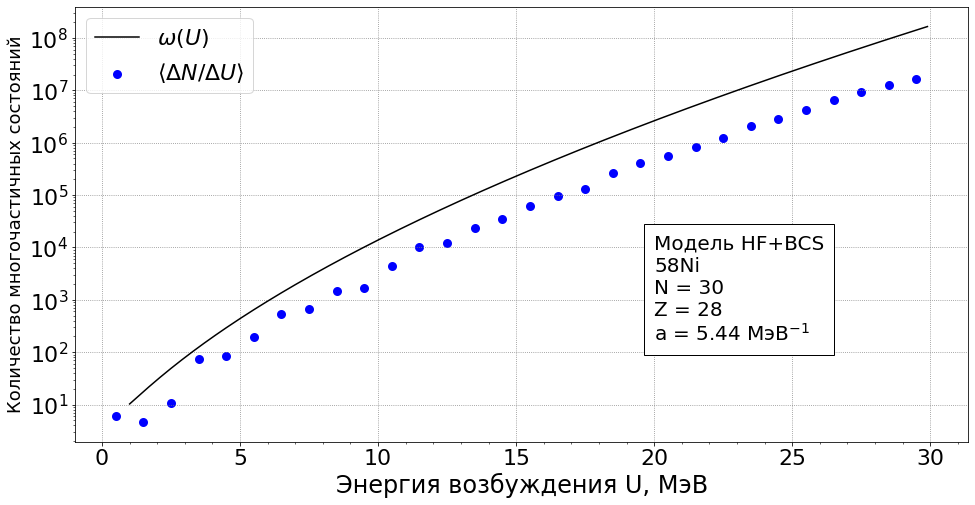

In [149]:
fig, graph = plt.subplots(figsize=(16, 8))

# dN_over_dU_arr_OSC58Ni = [6, 0, 24, 8, 224, 67, 1345, 620, 3232, 5120, 20317, 17872, 43816, 107376, 150712, 309314, 529284, 1007912, 1178196, 3021540]
# graph.scatter(U_axis, dN_over_dU_arr_OSC58Ni, linewidths=3, color='r' )

graph.set_xlabel("Энергия возбуждения U, МэВ", fontsize=24) # fontweight="bold"
graph.set_ylabel(f"Количество многочастичных состояний", fontsize=18)

plt.rcParams.update({'font.size': 22})

# graph.xaxis.set_major_locator(ticker.MultipleLocator(2))
graph.yaxis.set_major_locator(ticker.MultipleLocator(1))
graph.grid(which='major', color='gray', linestyle=':')
graph.minorticks_on()
# graph.grid(which='minor', axis='both', color='gray', linestyle=':')

graph.plot(Sokolov_246_formula_range, Sokolov_246_formula_values, 'k', label='$\omega(U)$')
# graph.scatter(U_axis, dN_over_dU_arr, linewidths=3, color='blue', label='$\Delta N / \Delta U$' )

# graph.scatter(U_axis, dN_over_dU_arr_smooth_erf, linewidths=3, color='red', label='Формула (21) в 2013 Uhrenholt')
graph.scatter(U_axis, dN_over_dU_arr_smooth, linewidths=3, color='blue', label='$\langle \Delta N / \Delta U \\rangle$' )

graph.set_yscale('log')

textHeight = math.log(max(dN_over_dU_arr) )*1e1
graph.text(20, textHeight, f'Модель HF+BCS\n'
                    f'{A}Ni\n'
                    f'N = {N_n}\n'
                    f'Z = {N_p}\n'
                    f'a = {a} МэВ${{}}^{{-1}}$',
           bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}, fontsize=20)
graph.legend()

                    # f'$\Delta_p$ = {round(DP, ndigits=2)} МэВ\n'
                    # f'$\Delta_n$ = {round(DN, ndigits=2)} МэВ\n'
                    
# Рассеять по энергетическому интервалу


In [39]:
(sum(dN_over_dU_arr_smooth) + dN_over_dU_arr[0] + dN_over_dU_arr[-1])/sum(dN_over_dU_arr)

1.0267034719117576

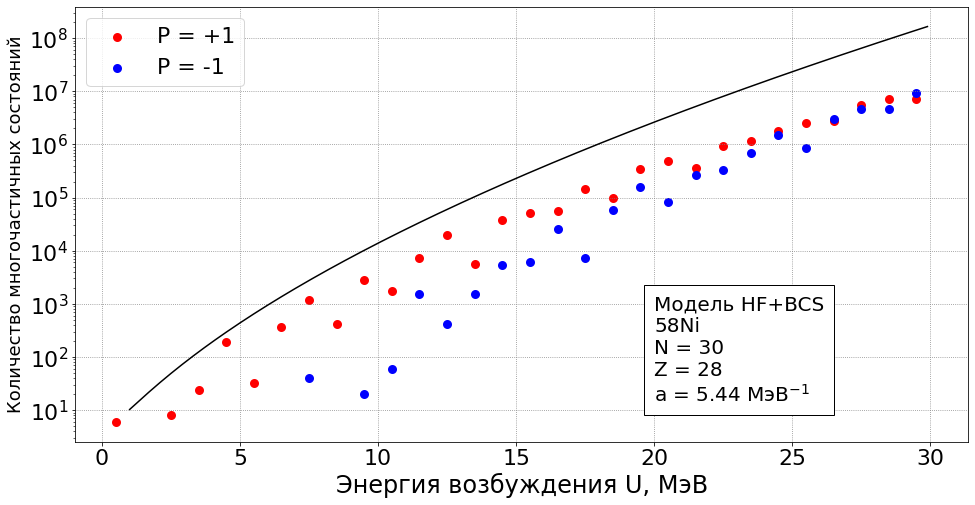

In [41]:
fig, graph = plt.subplots(figsize=(16, 8))

graph.set_xlabel("Энергия возбуждения U, МэВ", fontsize=24)
graph.set_ylabel(f"Количество многочастичных состояний", fontsize=18)

plt.rcParams.update({'font.size': 22})

graph.yaxis.set_major_locator(ticker.MultipleLocator(1))
graph.grid(which='major', color='gray', linestyle=':')
# graph.minorticks_on()
# graph.grid(which='minor', axis='both', color='gray', linestyle=':')

graph.plot(Sokolov_246_formula_range, Sokolov_246_formula_values, 'k')
graph.scatter(U_axis, dN_over_dU_parityP_arr, linewidths=3, color='red', label='P = +1' )
graph.scatter(U_axis, dN_over_dU_parityN_arr, linewidths=3, color='blue', label='P = -1' )

graph.set_yscale('log')

textHeight = math.log(max(dN_over_dU_parityP_arr) / 3)
graph.text(20, textHeight, f'Модель HF+BCS\n'
                    f'{A}Ni\n'
                    f'N = {N_n}\n'
                    f'Z = {N_p}\n'
                    f'a = {a} МэВ${{}}^{{-1}}$',
           bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}, fontsize=20)
graph.legend()


# Массив $J_Z$

In [42]:
J2z_array_parityP = {}
J2z_array_parityN = {}

# Требуется уточнение. Возможно, здесь ошибка. Для чётно-чётных ядер верно.
if N_n % 2 == 0:
    if N_p % 2 == 0:
        J_iter_lim = j2z_limit # N even P even
    else:
        J_iter_lim = j2z_limit - 1 # N even P odd
else:
    if N_p % 2 == 0:
        J_iter_lim = j2z_limit # N odd P even
    else:
        J_iter_lim = j2z_limit - 1 # N odd P odd

for energy in range(int(U / energy_step) + 1):
    energy = energy * energy_step
    tmp_J2z_array_P = []
    tmp_J2z_array_N = []
    for J2z in range(-j2z_limit, j2z_limit + 1):
        E_neutron = 0
        E_proton = energy
        J2z = abs(J2z)
        total_states_pariryP = 0
        total_states_pariryN = 0
        while E_neutron <= energy:
            for i in range(-J_iter_lim, J_iter_lim + 1 - J2z, 2):
                x1 = dNn_over_dU_over_d2jz_pariryP[E_neutron][j2z_limit + i + J2z]
                x2 = dNp_over_dU_over_d2jz_pariryP[E_proton][j2z_limit - i]
                total_states_pariryP += x1 * x2

                x1 = dNn_over_dU_over_d2jz_pariryN[E_neutron][j2z_limit + i + J2z]
                x2 = dNp_over_dU_over_d2jz_pariryN[E_proton][j2z_limit - i]
                total_states_pariryP += x1 * x2

                x1 = dNn_over_dU_over_d2jz_pariryN[E_neutron][j2z_limit + i + J2z]
                x2 = dNp_over_dU_over_d2jz_pariryP[E_proton][j2z_limit - i]
                total_states_pariryN += x1 * x2

                x1 = dNn_over_dU_over_d2jz_pariryP[E_neutron][j2z_limit + i + J2z]
                x2 = dNp_over_dU_over_d2jz_pariryN[E_proton][j2z_limit - i]
                total_states_pariryN += x1 * x2
                # print(f"(energy) {energy  : < 4} (J2z) {J2z : < 4} (j2z_limit + i + J2z) {j2z_limit + i + J2z : < 4} (j2z_limit - i) {j2z_limit - i : < 4} {total_states_pariryP != 0}")

            E_neutron += energy_step
            E_proton -= energy_step

        tmp_J2z_array_P.append(total_states_pariryP)
        tmp_J2z_array_N.append(total_states_pariryN)

    print(f"finished {energy} of out {int(U)}")

    J2z_array_parityP[energy] = tmp_J2z_array_P
    J2z_array_parityN[energy] = tmp_J2z_array_N
    
# Убираем все нулевые элементы на нечётных (или чётных) местах

Jz_array_parityP = J2z_array_parityP
Jz_array_parityN = J2z_array_parityN

del J2z_array_parityP
del J2z_array_parityN

if A % 2 == 0:
    start_selection = 1 # Удаление элементов +1, -1, +3, -3, ...
else:
    start_selection = 0 # Удаление элементов 0, +1, -1, ...

for energy in range(int(U / energy_step) + 1):
    energy = energy * energy_step
    del Jz_array_parityP[energy][start_selection::2]
    del Jz_array_parityN[energy][start_selection::2]

finished 0 of out 30
finished 1 of out 30
finished 2 of out 30
finished 3 of out 30
finished 4 of out 30
finished 5 of out 30
finished 6 of out 30
finished 7 of out 30
finished 8 of out 30
finished 9 of out 30
finished 10 of out 30
finished 11 of out 30
finished 12 of out 30
finished 13 of out 30
finished 14 of out 30
finished 15 of out 30
finished 16 of out 30
finished 17 of out 30
finished 18 of out 30
finished 19 of out 30
finished 20 of out 30
finished 21 of out 30
finished 22 of out 30
finished 23 of out 30
finished 24 of out 30
finished 25 of out 30
finished 26 of out 30
finished 27 of out 30
finished 28 of out 30
finished 29 of out 30
finished 30 of out 30


In [43]:
if A % 2 == 0:
    lim = 1
    length = int((len(Jz_array_parityP[0]) - 1) / 2)
    axis_J_array = [i for i in range(-length, length + 1)]
else:
    lim = 0

    length = int((len(Jz_array_parityP[0]) - 1) / 2)
    axis_J_array = [(i + 0.5) for i in range(-length - 1, length + 1)]

print(len(axis_J_array))

51


In [44]:
for i in range(U+energy_step):
    print(Jz_array_parityP[i])


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 7, 12, 17, 21, 23, 24, 23, 21, 17, 12, 7, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 5, 4, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 12, 22

## Линейное сглаживание по 3 точкам по энергии

In [ ]:
smoothing = 3
Jz_array_parityP_smooth = {}
Jz_array_parityN_smooth = {}

Jz_array_parityP_smooth[0] = Jz_array_parityP[0]
Jz_array_parityN_smooth[0] = Jz_array_parityN[0]

for i in range(1, len(Jz_array_parityP)-smoothing+2):
    Jz_array_parityP_smooth[i] = 0
    Jz_array_parityN_smooth[i] = 0

    for j in range(0, smoothing):
        Jz_array_parityP_smooth[i] += np.array(Jz_array_parityP[i-1+j])
        Jz_array_parityN_smooth[i] += np.array(Jz_array_parityN[i-1+j])

    Jz_array_parityP_smooth[i] = list(np.int64(Jz_array_parityP_smooth[i]/smoothing))
    Jz_array_parityN_smooth[i] = list(np.int64(Jz_array_parityN_smooth[i]/smoothing))


Jz_array_parityP_smooth[U] = Jz_array_parityP[U]
Jz_array_parityN_smooth[U] = Jz_array_parityN[U]

for i in range(U):
    print(Jz_array_parityP_smooth[i])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 6, 8, 9, 10, 9, 8, 6, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 5, 7, 9, 10, 11, 10, 9, 7, 5, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 12, 17, 22, 24, 25, 24, 22, 17, 12, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 11, 2

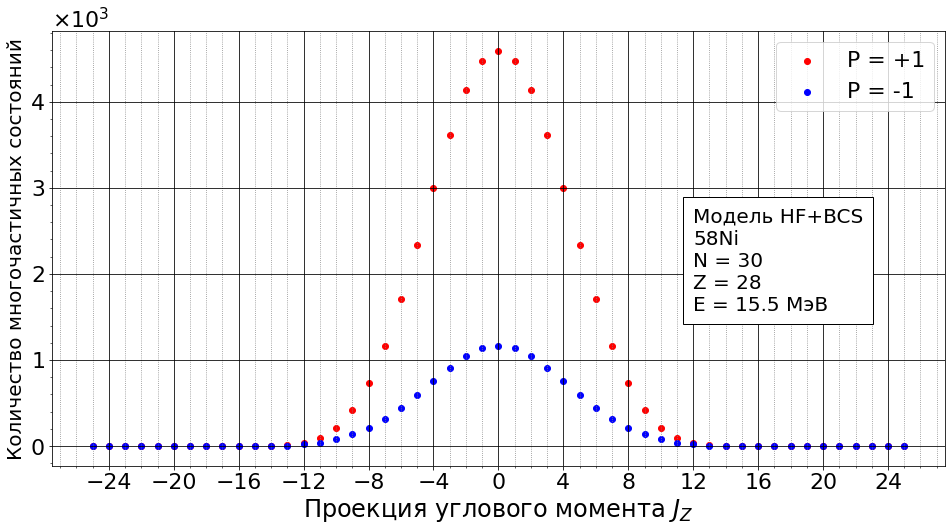

In [137]:
current_energy = 15
fig, graph = plt.subplots(figsize=(16, 8))

graph.set_xlabel("Проекция углового момента $J_Z$", fontsize=24)
graph.set_ylabel("Количество многочастичных состояний", fontsize=20)

# plt.rcParams.update({'font.size': 20})

graph.xaxis.set_major_locator(ticker.MultipleLocator(4))
graph.grid(which='major', color='k')
graph.minorticks_on()
graph.grid(axis='x', which='minor', color='gray', linestyle=':')

# graph.scatter(axis_J_array, Jz_array_parityP[current_energy], color='red', linewidths=1, label='P = +1')
# graph.scatter(axis_J_array, Jz_array_parityN[current_energy], color='blue', linewidths=1, label='P = -1')

graph.scatter(axis_J_array, Jz_array_parityP_smooth[current_energy], color='red', linewidths=1, label='P = +1')
graph.scatter(axis_J_array, Jz_array_parityN_smooth[current_energy], color='blue', linewidths=1, label='P = -1')

# graph.set_yscale('log')

textHeight = max(Jz_array_parityP[current_energy][int(j2z_limit/2)], Jz_array_parityN[current_energy][int(j2z_limit/2)]) / 3
graph.text(12, textHeight, f'Модель HF+BCS\n'
                    f'{A}Ni\n'
                    f'N = {N_n}\n'
                    f'Z = {N_p}\n'
                    f'E = 15.5 МэВ',
           bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}, fontsize=20)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
graph.yaxis.set_major_formatter(formatter)
graph.legend()

# Плотность уровней

In [46]:
start_index = int(len(Jz_array_parityP[0]) / 2) # Возможно, это j2z_limit/2

In [47]:
ad_1_or_0 = 1
if (A%2 == 0):
    ad_1_or_0 = 0
print(ad_1_or_0)

0


In [48]:
rho_array_parityP = {}
rho_array_parityN = {}

for energy in range(int(U / energy_step) + 1):
    energy = energy * energy_step
    tmp_parity_array_P = []
    tmp_parity_array_N = []

    for jz in range(start_index, start_index * 2 - ad_1_or_0): # !!! for 43sc -1
        p = Jz_array_parityP[energy]
        n = Jz_array_parityN[energy]

        tmp_parity_array_P.append(p[jz] - p[jz + 1])
        tmp_parity_array_N.append(n[jz] - n[jz + 1])

    rho_array_parityP[energy] = tmp_parity_array_P
    rho_array_parityN[energy] = tmp_parity_array_N


## Суммирование по чётностям

In [49]:
rho_array_parity_total = {}
for energy in range(int(U / energy_step) + 1):
    energy = energy * energy_step
    tmp_parity_array = []
    for i in range(len(rho_array_parityP[0])):
        tmp_parity_array.append(rho_array_parityP[energy][i] + rho_array_parityN[energy][i])

    rho_array_parity_total[energy] = tmp_parity_array

## Ось энергий

In [50]:
length = int((len(Jz_array_parityP[0]) - 1) / 2)
axis_J_array_rho = [i for i in range(length)]
print(axis_J_array_rho)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


## График. Плотность уровней в зависимости от $J_Z$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


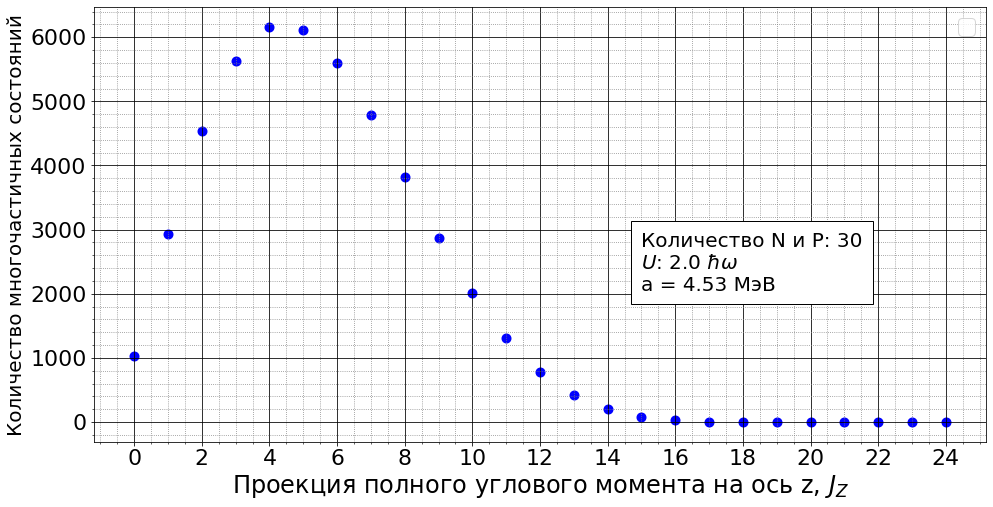

In [51]:
fig, graph = plt.subplots(figsize=(16, 8))

graph.set_xlabel("Проекция полного углового момента на ось z, $J_Z$", fontsize=24)
graph.set_ylabel("Количество многочастичных состояний", fontsize=20)

graph.xaxis.set_major_locator(ticker.MultipleLocator(2))
graph.grid(which='major', color='k')
graph.minorticks_on()
graph.grid(which='minor', color='gray', linestyle=':')

graph.scatter(axis_J_array_rho, rho_array_parity_total[current_energy], color='blue', linewidths=4)

# graph.set_yscale('log')

textHeight = max(rho_array_parity_total[current_energy]) / 3
reversedMeV = '{\text{МэВ}}^{-1}'
graph.text(15, textHeight, f'Количество N и P: {N_n}\n'
                    f'$U$: 2.0 $\hbar \omega$\n'
                    f'a = 4.53 МэВ', fontsize=20,
           bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
graph.legend()

# Плотность уровней в зависимости от энергии

In [52]:
rho_array_energy_total = []

for energy in range(len(U_axis)):
    rho_array_energy_total.append(sum(rho_array_parity_total[energy * energy_step]))


## Аналитическая формула $\rho(U)$

In [53]:
hw = 40 * pow(A, -1 / 3)
# a = 3.8

r_0 = 1.4
R_squared = (r_0 ** 2) * (A ** (2 / 3))
K = 197 * 197 / (4 / 5 * 939 * A * R_squared)

print("K", K)
print("R_squared", R_squared)

K 0.030330121200250002
R_squared 29.36802449523755


In [54]:
def rho_U_formula(U, a):
    return np.sqrt(K) * np.exp(2 * np.sqrt(a * U)) / (12 * pow(U, 3/2))

In [55]:
rho_U_formula_range = np.arange(0.5, U, 0.5).tolist()

In [56]:
rho_U_formula_values = []
for i in range(len(rho_U_formula_range)):
    rho_U_formula_values.append(rho_U_formula(rho_U_formula_range[i], a))

## График

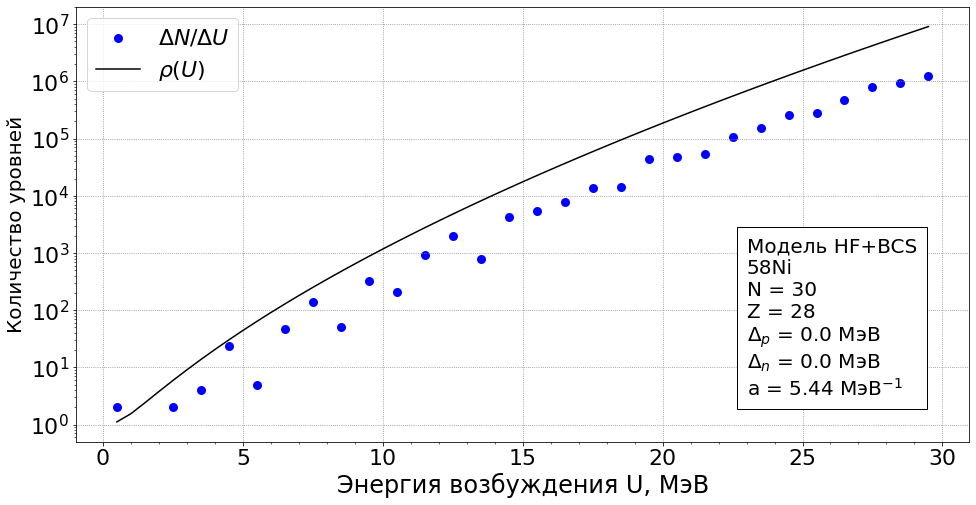

In [57]:
fig, graph = plt.subplots(figsize=(16, 8))

graph.set_xlabel("Энергия возбуждения U, МэВ", fontsize=24)
graph.set_ylabel("Количество уровней", fontsize=20)

# graph.xaxis.set_major_locator(ticker.MultipleLocator(2))
graph.yaxis.set_major_locator(ticker.MultipleLocator(1))
graph.grid(which='major', color='gray', linestyle=':')
graph.minorticks_on()
# graph.grid(which='minor', axis='both', color='gray', linestyle=':')

graph.scatter(U_axis, rho_array_energy_total, linewidths=3, color='blue', label='$\Delta N / \Delta U$')
graph.plot(rho_U_formula_range, rho_U_formula_values, 'k', label='$ρ(U)$')

graph.set_yscale('log')

textHeight = math.log(max(rho_array_energy_total) / 3)/4
graph.text(23, textHeight, f'Модель HF+BCS\n'
                    f'{A}Ni\n'
                    f'N = {N_n}\n'
                    f'Z = {N_p}\n'
                    f'$\Delta_p$ = {round(DP, ndigits=2)} МэВ\n'
                    f'$\Delta_n$ = {round(DN, ndigits=2)} МэВ\n'
                    f'a = {a} МэВ${{}}^{{-1}}$',
           bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}, fontsize=20)
graph.legend()

# Код, который, возможно, каким-то образом пригодится в будущем

### IAEA

In [58]:
# body = {
#     'fields': 'levels',
#     'nuclides': nucleus
#     }

# r = requests.get('https://nds.iaea.org/relnsd/v1/data', params = body)
# lines = r.text.split('\n')
# data = []

# for i in range(len(lines)):
#     if (len(lines[i])):
#         data.append(lines[i].split(','))
#         # print(data[i])

In [59]:
# energy = []

# for i in range(1, len(data)):
#     energy.append(float(data[i][5]))

In [60]:
# step = 1000 # 1 MeV

# rho = [0 for i in range(int(energy[-1]/step)+1)]

# # print(rho)

# for i in range(len(energy)):

#     index = int(energy[i]/step)

#     rho[index] += 1

# print(rho)

In [61]:
# axis = [i for i in range(int(energy[-1]/step)+1)]

## Plot

In [62]:
# fig, graph = plt.subplots(figsize=(18, 9))

# graph.set_xlabel("Энергия возбуждения U, МэВ", fontsize=24, fontweight="bold")
# graph.set_ylabel("Количество уровней", fontsize=18)

# # graph.xaxis.set_major_locator(ticker.MultipleLocator(2))
# graph.yaxis.set_major_locator(ticker.MultipleLocator(1))
# graph.grid(which='major', color='k')
# graph.minorticks_on()
# graph.grid(which='minor', axis='both', color='gray', linestyle=':')

# graph.plot(rho_U_formula_range, rho_U_formula_values, 'k', label='Analytical formula')
# graph.scatter(axis, rho, linewidths=1, color='blue', label='IAEA levels')
# graph.scatter(U_axis, rho_array_energy_total, linewidths=1, color='red', label='my 40Ca levels' )

# graph.set_yscale('log')
# # graph.yaxis.set_major_locator(ticker.MultipleLocator(1))

# graph.set_xlim([-1, 30])

# graph.text(1, 1e3, f' {A}{element[N_p]}\n a = {a} МэВ$^{{-1}}$',
#                       fontweight = 'bold',
#            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}, fontsize=16)
# graph.legend()

### Спаривание нуклонов. Алгоритм

In [63]:
# PAIRING ALGORITHM. 1ST ATTEMPT

# def ens_energy_pairing(ensemble):
#     summ = 0

#     # calculate ground state bound particles' energy
#     if nucl_type == 'n':
#         N = N_n
#     elif nucl_type == 'p':
#         N = N_p

#     # for i in range(0, N, 2):
#     #     if(ensemble[i] == 1 and ensemble[i+1] == 1):
#     #         print('inside')
#     #         summ += particles[i].get_energy() * 2
#     #         if particles[i].get_energy() != particles[i+1].get_energy():
#     #             raise Exception("ERROR Bound patricles have different energies")
#     # print('gs', summ)

#     # calculate quasiparticles' energy
#     checked_hole = N-1
#     for id_ex_particle in range(len(ensemble)-1, N-1, -1):
#         if ensemble[id_ex_particle] == 0:
#             continue

#         # нашли частицу, где ensemble[id_ex_particle] == 1
#         for id_ex_hole in range(checked_hole, -1, -1):
#             if ensemble[id_ex_hole] == 0:
#                 summ += math.sqrt( (particles[id_ex_particle].get_energy() - particles[id_ex_hole].get_energy())**2 + D**2 )
#                 checked_hole -= 1
#                 break
#             else:
#                 # есть частица в основном состоянии. Нужно определить, спарена ли она, и расчитать её энергию

#                 print('inside else')
#                 if id_ex_hole%2 == 0: # если мы на чётной позиции (левая частица в паре)

#                     # if ensemble[id_ex_hole+1] == 1: # если есть рядом частица # МЫ УЖЕ ОТРАБОТАЛИ ЭТОТ СЛУЧАЙ
#                     #     summ += particles[id_ex_hole].get_energy() * 2

#                     #     if particles[id_ex_hole].get_energy() != particles[id_ex_hole+1].get_energy():
#                     #         raise Exception("ERROR Bound patricles have different energies (GS)")
                        
#                     if ensemble[id_ex_hole+1] == 0:
#                         summ += D

#                 checked_hole -= 1

    
#     # если вышли, но не посчитали левую частицу в паре из-за break около checked_hole
#     if ensemble[id_ex_hole] == 1 and ensemble[id_ex_hole+1] == 0:
#         summ += D


#     return summ


### Конвертирование [1,0,...] в [2,4,2,6,...]

In [64]:
# Конвертирование [1,0,...] в [2,4,2,6,...], т.е. массива чисел заполнения в массив по энергетическим уровням.
# Но нужен массив init_info из предыдущих версий

# def convert(ens):
#     level_array = [] # [2,4,2,6,...]
#     level_shift = 0

#     for level in init_info:
#         n_particles = 0

#         # print(level_shift)
#         for i in range(level[0]*2):
#             n_particles += ens[i+level_shift]

#         level_array.append(n_particles)
#         level_shift += level[0]*2

#     return level_array
       
# proton_converted = {}
# neutron_converted = {}

# # Test
# convert([1,0,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

### HF BCS part

cccccccccccccc Ni58 (+3n +3p states) cccccccccccccccccccc
data ln/31/,l/15,16,0/,
*alo/2,4,2,6,2,4,8,0,0,0,0,0,0,0,0,
*2,4,2,6,2,4,8,2,0,0,0,0,0,0,0,0,9*0./
data al/0.,1.,1.,2.,0.,2.,3.,1.,3.,1.,4.,2.,4.,0.,2.,
*0.,1.,1.,2.,0.,2.,3.,1.,3.,1.,4.,2.,4.,0.,2.,5.,9*0./
data aj/.5,1.5,.5,2.5,.5,1.5,3.5,1.5,2.5,0.5,4.5,2.5,3.5,0.5,1.5,
*.5,1.5,.5,2.5,.5,1.5,3.5,1.5,2.5,0.5,4.5,2.5,3.5,0.5,1.5,5.5,9*0./
data en/-60.,-50.,-45.,-40.,-35.,-30.,-25.,-10.,-5.,-1.,-1.,
*-1.,-1,-1,-1,
*-60.,-50.,-45.,-40.,-35.,-30.,-25.,-20.,-15.,-10.,-10.,-10.,-10.,
*-10.,-10.,-10.,9*0./
data h1,h2,n,ht,rt/.015,.125,794,.02,.39/
data bf/2.6,2.4,2.4,2.1,2.1,1.9,1.8,1.7,1.7,1.6,1.6,1.5,1.5,1.4,
*1.4,
*2.6,2.4,2.3,2.1,2.0,1.9,1.8,1.7,1.6,1.5,1.4,1.3,1.2,1.2,1.2,1.2,
*9*0./

In [65]:
# proton_converted_sorted = collections.OrderedDict(sorted(proton_converted.items()))
# proton_values = list(val for val in proton_converted_sorted.values())
# proton_keys = list(val for val in proton_converted_sorted.keys())

# i = 0
# while i < len(proton_values)-1:
#     j = i+1
#     while j < len(proton_values):
#         if np.array_equal(proton_values[i], proton_values[j]):
#             proton_keys.remove(proton_keys[j])
#             proton_values.remove(proton_values[j])
#             j -= 1
#         j += 1
#     i += 1

# # There should be 3 free spaces in protons, not 4.as_integer_ratio

# i = 0
# while i < len(proton_values):
#     if proton_values[i][10] != 0:
#         proton_keys.remove(proton_keys[i])
#         proton_values.remove(proton_values[i])
#         i -= 1
#     else:
#         proton_values[i] = proton_values[i][:-1]

#     i += 1


# neutron_converted_sorted = collections.OrderedDict(sorted(neutron_converted.items()))
# neutron_values = list(val for val in neutron_converted_sorted.values())
# # for i in range(len(neutron_values)):
# #     neutron_values[i] = ''.join(str(x) for x in neutron_values[i])
# # neutron_values = list(set(neutron_values))
# neutron_keys = list(val for val in neutron_converted_sorted.keys())

# i = 0
# while i < len(proton_values)-1:
#     j = i+1
#     while j < len(proton_values):
#         if np.array_equal(proton_values[i], proton_values[j]):
#             proton_keys.remove(proton_keys[j])
#             proton_values.remove(proton_values[j])
#             j -= 1
#         j += 1
#     i += 1


# converted_sorted = {} # {energy, [protons, neutrons]}

# for i in range(len(proton_values)):
#     for j in range(len(neutron_values)):
#         converted_sorted[proton_keys[i]+neutron_keys[j]] = proton_values[i] + neutron_values[j]



# converted_sorted = collections.OrderedDict(sorted(converted_sorted.items()))
# values = list(val for val in converted_sorted.values())
# keys = list(val for val in converted_sorted.keys())


# index = 1
# print('c     *alo/' + ','.join(str(x) for x in values[0]) + ',0,18*0./    c', 0, keys[0])
# for i in range(1, len(values)):
#     if values[i] != values[i-1]:
#         if sum(values[i]) != N_p+N_n:
#             raise Exception('number error')
        
#         if keys[i] < 11.0:
#             print('c     *alo/' + ','.join(str(x) for x in values[i]) + ',0,18*0./    c', index, keys[i])
#             index += 1
